In [1]:
%cd ~ /projects/GraB-lib

%load_ext autoreload
%autoreload 1

/home/aris/projects/GraB-lib


In [2]:
from torch import nn

import os
import sys
from functools import partial, reduce
from pathlib import Path
from dataclasses import dataclass, field

import evaluate
import numpy as np
import pandas as pd
import wandb
from tqdm import tqdm
from absl import logging

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from transformers import (
    HfArgumentParser, TrainingArguments, set_seed, Conv1D
)

import torchopt
from torch.func import (
    grad, grad_and_value, vmap, functional_call
)

from grabngo import GraBSampler, BalanceType
from grabngo.utils import EventTimer, pretty_time

from experiments.cv.models import LeNet

In [3]:
device = "cuda"
batch_size = 16
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.49139968, 0.48215841, 0.44653091],
            std=[0.24703223, 0.24348513, 0.26158784],
        ),
    ]
)

# Loading the dataset and preprocessing
train_dataset = datasets.CIFAR10(
    root="data/external", train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root="data/external", train=False, download=True, transform=transform
)

in_dim, num_classes = 3, 10

loss_fn = nn.CrossEntropyLoss().to(device)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    # sampler=sampler,
    persistent_workers=False,
    num_workers=1,
    pin_memory=True,
)
train_eval_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    persistent_workers=False,
    num_workers=1,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    persistent_workers=False,
    num_workers=1,
    pin_memory=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
logging.set_verbosity(logging.INFO)

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [6]:
@torch.no_grad()
def unfold_model(model):
    return torch.cat([
        p.view(-1) for p in model.parameters()
    ])

In [7]:
checkpoint_path = Path(
    'checkpoints/cifar10/lenet/cifar10_lenet_rr_sgd_lr_0.01_wd_0.01_b_16_seed_42_epoch_100.pt')

trained_model = LeNet().cuda()
trained_model.load_state_dict(torch.load(checkpoint_path))

trained_weight = unfold_model(trained_model)

In [8]:
set_seed(42)

inited_model = LeNet().cuda()

inited_weight = unfold_model(inited_model)

In [9]:
def subtract(m1, m2):
    return dict(
        (k, p1 - p2)
        for (k, p1), (_, p2) in zip(m1.named_parameters(), m2.named_parameters())
    )


diff_model = subtract(trained_model, inited_model)

In [53]:
from scipy.stats import wasserstein_distance, norm


def describe(k, x):
    print(k)
    print(x.shape)
    print('min ', x.min().item())
    print('max ', x.max().item())
    print('meam', x.mean().item())
    print('std ', x.std().item())
    print('-' * 20)

# [describe(k, p) for k, p in dict(trained_model.named_parameters()).items()]
# [describe(k, p) for k, p in diff_model.items()]

In [11]:
diff = trained_weight - inited_weight

print(diff.abs().max())
print(diff.abs().min())
print(diff.abs().mean())
print(diff.abs().std())

print('-' * 20)

print(diff.max())
print(diff.min())
print(diff.mean())
print(diff.std())

tensor(0.7508, device='cuda:0')
tensor(7.7859e-07, device='cuda:0')
tensor(0.0361, device='cuda:0')
tensor(0.0323, device='cuda:0')
--------------------
tensor(0.5990, device='cuda:0')
tensor(-0.7508, device='cuda:0')
tensor(0.0004, device='cuda:0')
tensor(0.0484, device='cuda:0')


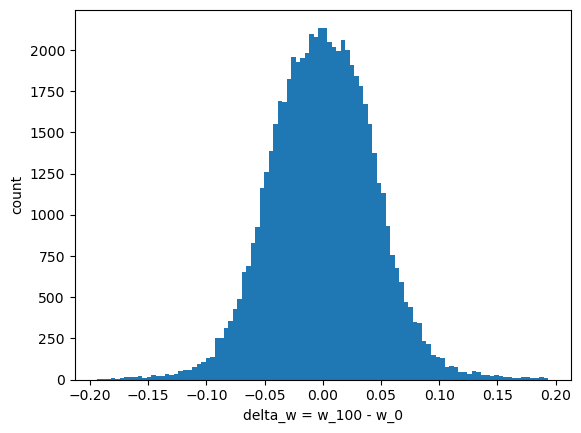

In [12]:
r = diff.std().item() * 4

plt.hist(diff.cpu().detach().numpy(), bins=100, range=(-r, r))
plt.xlabel('delta_w = w_100 - w_0')
plt.ylabel('count')
plt.show()

In [13]:
import kmeans1d

clusters, centroids = kmeans1d.cluster(diff.cpu().detach().numpy(), 16)

print(clusters)
print(centroids)

quant_diff = torch.tensor(np.array(centroids)[clusters], dtype=torch.float32,
                          device='cuda')
print(quant_diff)

[7, 5, 11, 4, 12, 13, 14, 5, 2, 12, 10, 13, 6, 3, 2, 12, 11, 11, 7, 2, 11, 12, 13, 3, 8, 8, 4, 3, 2, 9, 5, 13, 1, 1, 2, 9, 12, 2, 1, 2, 9, 13, 5, 1, 1, 12, 10, 10, 3, 5, 14, 12, 10, 1, 3, 13, 12, 5, 1, 4, 14, 15, 8, 2, 1, 14, 13, 14, 6, 2, 9, 13, 10, 13, 10, 15, 15, 15, 15, 13, 13, 13, 11, 15, 14, 3, 1, 1, 2, 3, 3, 4, 1, 1, 4, 7, 2, 9, 5, 4, 9, 8, 13, 14, 10, 3, 2, 4, 13, 14, 1, 0, 0, 1, 5, 11, 5, 6, 2, 4, 12, 13, 13, 12, 8, 12, 12, 14, 9, 11, 2, 2, 10, 8, 13, 5, 3, 2, 1, 8, 11, 14, 4, 10, 8, 13, 13, 13, 9, 13, 7, 12, 11, 13, 4, 11, 6, 2, 2, 14, 2, 13, 1, 1, 15, 5, 15, 1, 0, 15, 4, 14, 6, 0, 14, 8, 12, 3, 2, 13, 5, 8, 2, 3, 13, 4, 14, 1, 0, 15, 7, 15, 1, 0, 15, 5, 15, 12, 0, 13, 10, 10, 3, 4, 9, 9, 13, 11, 8, 13, 2, 13, 4, 1, 15, 1, 15, 3, 0, 15, 5, 14, 14, 0, 14, 3, 11, 14, 12, 10, 14, 14, 3, 0, 3, 14, 8, 0, 2, 15, 6, 1, 1, 15, 14, 7, 6, 13, 14, 3, 8, 14, 14, 7, 3, 14, 14, 9, 0, 3, 13, 11, 0, 2, 14, 2, 0, 1, 14, 15, 1, 7, 12, 13, 2, 3, 13, 12, 2, 9, 11, 15, 7, 1, 11, 14, 13, 0, 1, 14,

In [14]:
from scipy.stats import norm

miu, sigma = diff.mean().item(), diff.std().item()
print(miu, sigma)

diff_z = diff.cpu().detach().numpy()

diff_u = norm.cdf(diff_z, loc=miu, scale=sigma)

clusters, centroids = kmeans1d.cluster(diff_u, 16)

# print(clusters)
print(centroids)

quant_diff_u = np.array(centroids, dtype=float)[clusters]
print(quant_diff_u)
quant_diff = norm.ppf(quant_diff_u, loc=miu, scale=sigma)
quant_diff = torch.tensor(quant_diff, dtype=torch.float32, device='cuda')
print(quant_diff)

0.00042174223926849663 0.0484360009431839
[0.03305592909394156, 0.10022810425690501, 0.162864120531177, 0.2242996362990293, 0.28723189812743644, 0.3492384701491211, 0.41080732776678514, 0.4722262377534446, 0.5329799620654198, 0.594864241963482, 0.6560124184617099, 0.7165681377012619, 0.7770407589346549, 0.8383886790483497, 0.9015064120374721, 0.9704751604911382]
[0.41080733 0.22429964 0.90150641 ... 0.03305593 0.97047516 0.03305593]
tensor([-0.0105, -0.0363,  0.0629,  ..., -0.0886,  0.0919, -0.0886],
       device='cuda:0')


In [15]:
clusters, centroids = kmeans1d.cluster(trained_weight.cpu().detach().numpy(), 4)

print(clusters)
print(centroids)

quant_diff = torch.tensor(np.array(centroids)[clusters], dtype=torch.float32,
                          device='cuda')
print(quant_diff)

[2, 2, 2, 2, 2, 3, 3, 2, 0, 1, 3, 3, 2, 0, 0, 2, 3, 2, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 1, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 3, 3, 0, 0, 0, 3, 3, 2, 0, 0, 3, 3, 2, 0, 0, 3, 3, 3, 2, 0, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 3, 3, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 3, 2, 1, 0, 1, 2, 3, 2, 2, 0, 0, 0, 2, 3, 0, 0, 0, 0, 1, 2, 2, 2, 0, 1, 3, 3, 3, 3, 2, 1, 2, 2, 2, 2, 1, 2, 0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 2, 0, 3, 0, 1, 0, 0, 1, 1, 2, 0, 0, 3, 1, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 2, 0, 3, 0, 1, 1, 1, 2, 0, 2, 0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 3, 0, 3, 0, 3, 3, 1, 0, 3, 3, 0, 0, 0, 3, 1, 0, 0, 3, 2, 0, 0, 3, 3, 0, 0, 3, 3, 0, 0, 2, 3, 0, 0, 2, 3, 0, 0, 0, 3, 1, 0, 0, 3, 1, 0, 0, 3, 3, 0, 0, 3, 3, 0, 0, 2, 3, 0, 0, 2, 3, 1, 0, 1, 3, 1, 0, 0, 3, 1, 0, 0, 3, 3, 0, 0, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 

In [16]:
@torch.no_grad()
def apply_diff(module, delta, replace=False):
    idx = 0
    for p in module.parameters():
        d = p.numel()
        if replace:
            p.copy_(delta[idx:idx + d].reshape(p.shape))
        else:
            p += delta[idx:idx + d].reshape(p.shape)
        idx += d


set_seed(42)

inited_model = LeNet().cuda()

apply_diff(inited_model, quant_diff, replace=True)

diff_model = inited_model

set_seed(42)

inited_model = LeNet().cuda()

assert not torch.allclose(next(inited_model.parameters()),
                          next(diff_model.parameters()))

In [17]:
@torch.no_grad()
def validate(
        test_loader,
        model,
        loss_fn,
        no_tqdm=False,
        device: torch.device = torch.device("cuda"),
):
    metric = evaluate.load('accuracy')
    running_loss = 0.0
    # look over the validation dataloader
    for _, (x, y) in tqdm(
            enumerate(test_loader), total=len(test_loader), leave=False, disable=no_tqdm
    ):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        loss = loss_fn(outputs, y)
        running_loss += loss.item()
        metric.add_batch(predictions=outputs.argmax(dim=-1), references=y)
    return running_loss / len(test_loader), metric.compute()


loss, acc = validate(
    test_loader=test_loader,
    model=trained_model,
    loss_fn=loss_fn,
)

print(f"loss: {loss} accuracy: {acc['accuracy']}")

loss: 1.0266433548927307 accuracy: 0.6512


In [18]:

loss, acc = validate(
    test_loader=test_loader,
    model=diff_model,
    loss_fn=loss_fn,
)

print(f"loss: {loss} accuracy: {acc['accuracy']}")

loss: 2.9002679988861084 accuracy: 0.112


In [19]:

loss, acc = validate(
    test_loader=test_loader,
    model=LeNet().cuda(),
    loss_fn=loss_fn,
)

print(f"loss: {loss} accuracy: {acc['accuracy']}")

loss: 2.305189839553833 accuracy: 0.1004


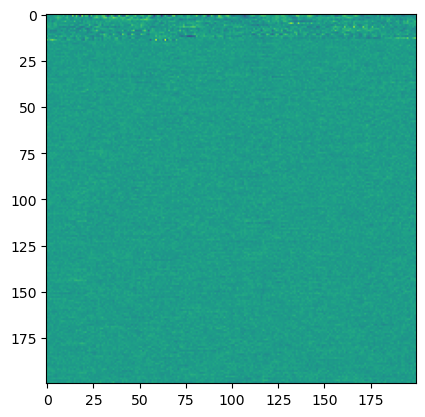

In [20]:
size = 200
plt.imshow(diff[:size ** 2].reshape(size, size).cpu().detach().numpy())

In [21]:
from torchinfo import summary

summary(trained_model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [10]                      --
├─Sequential: 1-1                        [1, 120, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 6, 28, 28]            456
│    └─ReLU: 2-2                         [1, 6, 28, 28]            --
│    └─MaxPool2d: 2-3                    [1, 6, 14, 14]            --
│    └─Conv2d: 2-4                       [1, 16, 10, 10]           2,416
│    └─ReLU: 2-5                         [1, 16, 10, 10]           --
│    └─MaxPool2d: 2-6                    [1, 16, 5, 5]             --
│    └─Conv2d: 2-7                       [1, 120, 1, 1]            48,120
│    └─ReLU: 2-8                         [1, 120, 1, 1]            --
├─Sequential: 1-2                        [10]                      --
│    └─Linear: 2-9                       [84]                      10,164
│    └─ReLU: 2-10                        [84]                      --
│  

In [22]:
multipliers = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 3]

losses, accs, sparsities = [], [], []
for m in multipliers:
    set_seed(42)
    model = LeNet().cuda()

    quant_diff, sparsity = compress(
        diff,
        outlier_multiplier=m,
        add_noise=False,
    )
    apply_diff(model, quant_diff)
    loss, acc = validate(test_loader, model, loss_fn)

    losses.append(loss)
    accs.append(acc)
    sparsities.append(sparsity)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:8                                                                                    │
│                                                                                                  │
│    5 │   set_seed(42)                                                                            │
│    6 │   model = LeNet().cuda()                                                                  │
│    7 │                                                                                           │
│ ❱  8 │   quant_diff, sparsity = compress(                                                        │
│    9 │   │   diff,                                                                               │
│   10 │   │   outlier_multiplier=m,                                                               │
│   11 │   │   add_noise=False,                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'compress' is not defined

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 plt.plot(multipliers[:-3], [e['accuracy'] for e in accs][:-3])                               │
│   2 plt.xlabel(                                                                                  │
│   3 │   'Multiplier alpha -- we prune the elements of delta_w\nwhose value within (miu ± alp     │
│   4 plt.ylabel('Accuracy after applying sparsified delta_w to w_0')                              │
│                                                                                                  │
│ /home/aris/mambaforge/envs/grab/lib/python3.10/site-packages/matplotlib/pyplot.py:2812 in plot   │
│                                                                                                  │
│   2809 # Autogenerated by boilerplate.py.  Do not edit as changes will be lost.                  │
│   2810 @_copy_docstring_and_deprecators(Axes.plot)                                               │
│   2811 def plot(*args, scalex=True, scaley=True, data=None, **kwargs):                           │
│ ❱ 2812 │   return gca().plot(                                                                    │
│   2813 │   │   *args, scalex=scalex, scaley=scaley,                                              │
│   2814 │   │   **({"data": data} if data is not None else {}), **kwargs)                         │
│   2815                                                                                           │
│                                                                                                  │
│ /home/aris/mambaforge/envs/grab/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1688 in    │
│ plot                                                                                             │
│                                                                                                  │
│   1685 │   │   (``'green'``) or hex strings (``'#008000'``).                                     │
│   1686 │   │   """                                                                               │
│   1687 │   │   kwargs = cbook.normalize_kwargs(kwargs, mlines.Line2D)                            │
│ ❱ 1688 │   │   lines = [*self._get_lines(*args, data=data, **kwargs)]                            │
│   1689 │   │   for line in lines:                                                                │
│   1690 │   │   │   self.add_line(line)                                                           │
│   1691 │   │   if scalex:                                                                        │
│                                                                                                  │
│ /home/aris/mambaforge/envs/grab/lib/python3.10/site-packages/matplotlib/axes/_base.py:311 in     │
│ __call__                                                                                         │
│                                                                                                  │
│    308 │   │   │   if args and isinstance(args[0], str):                                         │
│    309 │   │   │   │   this += args[0],                                                          │
│    310 │   │   │   │   args = args[1:]                                                           │
│ ❱  311 │   │   │   yield from self._plot_args(                                                   │
│    312 │   │   │   │   this, kwargs, ambiguous_fmt_datakey=ambiguous_fmt_datakey)                │
│    313 │                                                                                         │
│    314 │   def get_next_color(self):                                                             │
│                                                            

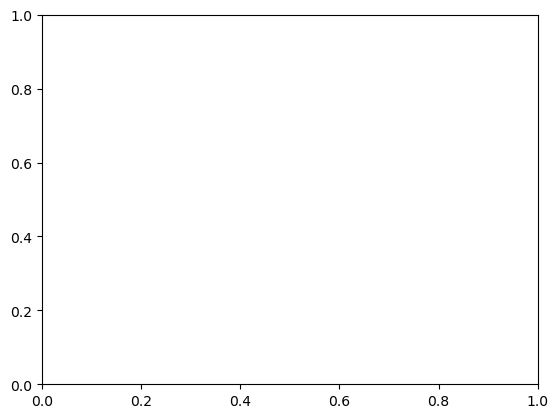

In [23]:
plt.plot(multipliers[:-3], [e['accuracy'] for e in accs][:-3])
plt.xlabel(
    'Multiplier alpha -- we prune the elements of delta_w\nwhose value within (miu ± alpha * sigma)\nEmpirically, miu=4e-4 and sigma~=5e-3')
plt.ylabel('Accuracy after applying sparsified delta_w to w_0')
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 plt.plot(multipliers, losses)                                                                │
│   2                                                                                              │
│                                                                                                  │
│ /home/aris/mambaforge/envs/grab/lib/python3.10/site-packages/matplotlib/pyplot.py:2812 in plot   │
│                                                                                                  │
│   2809 # Autogenerated by boilerplate.py.  Do not edit as changes will be lost.                  │
│   2810 @_copy_docstring_and_deprecators(Axes.plot)                                               │
│   2811 def plot(*args, scalex=True, scaley=True, data=None, **kwargs):                           │
│ ❱ 2812 │   return gca().plot(                                                                    │
│   2813 │   │   *args, scalex=scalex, scaley=scaley,                                              │
│   2814 │   │   **({"data": data} if data is not None else {}), **kwargs)                         │
│   2815                                                                                           │
│                                                                                                  │
│ /home/aris/mambaforge/envs/grab/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1688 in    │
│ plot                                                                                             │
│                                                                                                  │
│   1685 │   │   (``'green'``) or hex strings (``'#008000'``).                                     │
│   1686 │   │   """                                                                               │
│   1687 │   │   kwargs = cbook.normalize_kwargs(kwargs, mlines.Line2D)                            │
│ ❱ 1688 │   │   lines = [*self._get_lines(*args, data=data, **kwargs)]                            │
│   1689 │   │   for line in lines:                                                                │
│   1690 │   │   │   self.add_line(line)                                                           │
│   1691 │   │   if scalex:                                                                        │
│                                                                                                  │
│ /home/aris/mambaforge/envs/grab/lib/python3.10/site-packages/matplotlib/axes/_base.py:311 in     │
│ __call__                                                                                         │
│                                                                                                  │
│    308 │   │   │   if args and isinstance(args[0], str):                                         │
│    309 │   │   │   │   this += args[0],                                                          │
│    310 │   │   │   │   args = args[1:]                                                           │
│ ❱  311 │   │   │   yield from self._plot_args(                                                   │
│    312 │   │   │   │   this, kwargs, ambiguous_fmt_datakey=ambiguous_fmt_datakey)                │
│    313 │                                                                                         │
│    314 │   def get_next_color(self):                                                             │
│                                                                                                  │
│ /home/aris/mambaforge/envs/grab/lib/python3.10/site-packages/matplotlib/axes/_base.py:504 in     │
│ _plot_args                                                 

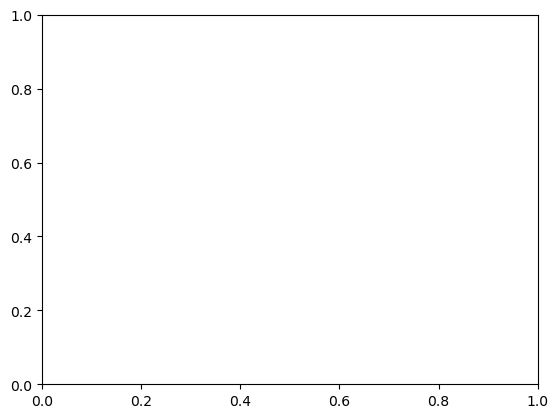

In [24]:
plt.plot(multipliers, losses)

In [ ]:
densities = sparsities

In [25]:
plt.plot([s.cpu() for s in densities][:-3], [e['accuracy'] for e in accs][:-3])
plt.xlabel(
    'Density of delta_w from random initialization\nafter pruning the smallest absolute values')
plt.ylabel('Accuracy after applying sparsified delta_w to w_0')
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 plt.plot([s.cpu() for s in densities][:-3], [e['accuracy'] for e in accs][:-3])              │
│   2 plt.xlabel(                                                                                  │
│   3 │   'Density of delta_w from random initialization\nafter pruning the smallest absolute      │
│   4 plt.ylabel('Accuracy after applying sparsified delta_w to w_0')                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'densities' is not defined

In [26]:
plt.plot([s.cpu() for s in densities][:-3], losses[:-3])
plt.xlabel(
    'Density of delta_w from random initialization\nafter pruning the smallest absolute values')
plt.ylabel('Loss after applying sparsified delta_w to w_0')
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 plt.plot([s.cpu() for s in densities][:-3], losses[:-3])                                     │
│   2 plt.xlabel(                                                                                  │
│   3 │   'Density of delta_w from random initialization\nafter pruning the smallest absolute      │
│   4 plt.ylabel('Loss after applying sparsified delta_w to w_0')                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'densities' is not defined

In [163]:
from transformers import set_seed, AutoConfig, AutoModel, GPT2PreTrainedModel, \
    AutoModelForCausalLM


def _init_weights(module):
    """ Initialize the weights.
    """
    if isinstance(module, (nn.Linear, nn.Embedding, Conv1D)):
        # Slightly different from the TF version which uses truncated_normal for initialization
        # cf https://github.com/pytorch/pytorch/pull/5617
        module.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, (nn.Linear, Conv1D)) and module.bias is not None:
            module.bias.data.zero_()
    elif isinstance(module, nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)


seed = 4

config = AutoConfig.from_pretrained('gpt2')
config.update_from_string(
    'n_embd=128,n_ctx=128,n_layer=4,n_head=2,n_positions=128,summary_first_dropout=0,attn_pdrop=0,resid_pdrop=0,embd_pdrop=0')

print(config)
set_seed(seed)
gpt_init = AutoModelForCausalLM.from_config(config).cuda()
gpt_trained = AutoModelForCausalLM.from_config(config).cuda()
gpt_trained.load_state_dict(
    torch.load('checkpoints/gpt2/wikitext/recursive/step_100000_model.pt'))
gpt_trained2 = AutoModelForCausalLM.from_config(config).cuda()
# gpt_trained2.load_state_dict(torch.load('checkpoints/gpt2/wikitext/rr/42/step_100000_model.pt'))
gpt_trained2.load_state_dict(
    torch.load('checkpoints/gpt2/wikitext/recursive/step_75000_model.pt'))
# gpt_trained = AutoModel.from_pretrained('gpt2').cuda()

# [gpt_init._init_weights(p) for p in gpt_init.modules()]

# set_seed(seed)
# [gpt_trained._init_weights(p) for p in gpt_trained.modules()]


# [describe(k, p) for k, p in dict(gpt_init.named_parameters()).items()]
# [describe(k, p) for k, p in dict(gpt_trained.named_parameters()).items()]
# 
diff_gpt = subtract(gpt_trained, gpt_init)

[describe(k, p) for k, p in diff_gpt.items() if 'c_fc.weight' in k]
# gpt_diff_weights = unfold_model(gpt_trained) - unfold_model(gpt_trained2)
gpt_diff_weights = unfold_model(gpt_trained) - unfold_model(gpt_init)
# [describe(k, p) for k, p in gpt_diff_weights.items()]
# gpt_diff_weights = unfold_model(gpt_trained2) - unfold_model(gpt_init)

# describe('gpt_diff_weights', gpt_diff_weights)

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.0,
  "bos_token_id": 50256,
  "embd_pdrop": 0.0,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 128,
  "n_embd": 128,
  "n_head": 2,
  "n_inner": null,
  "n_layer": 4,
  "n_positions": 128,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.0,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.0,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.29.2",
  "use_cache": true,
  "vocab_size": 50257
}
transformer.h.0.mlp.c_fc.weight
torch.Size([128, 512])
min  -1.1385976076126099
max  1.2075008153915405
meam 0.002

In [62]:
"""
wte: word token embeddings
Thus, so what we can be reasonably certain that wte is a look-up table which holds all the vectors that correspond to the token values!

wpe: word position embeddings
What wpe basically does is to tell the model basically where a particular word is!
"""

[f'{k}: {p.shape}' for k, p in gpt_init.named_parameters()]

['transformer.wte.weight: torch.Size([50257, 128])',
 'transformer.wpe.weight: torch.Size([128, 128])',
 'transformer.h.0.ln_1.weight: torch.Size([128])',
 'transformer.h.0.ln_1.bias: torch.Size([128])',
 'transformer.h.0.attn.c_attn.weight: torch.Size([128, 384])',
 'transformer.h.0.attn.c_attn.bias: torch.Size([384])',
 'transformer.h.0.attn.c_proj.weight: torch.Size([128, 128])',
 'transformer.h.0.attn.c_proj.bias: torch.Size([128])',
 'transformer.h.0.ln_2.weight: torch.Size([128])',
 'transformer.h.0.ln_2.bias: torch.Size([128])',
 'transformer.h.0.mlp.c_fc.weight: torch.Size([128, 512])',
 'transformer.h.0.mlp.c_fc.bias: torch.Size([512])',
 'transformer.h.0.mlp.c_proj.weight: torch.Size([512, 128])',
 'transformer.h.0.mlp.c_proj.bias: torch.Size([128])',
 'transformer.h.1.ln_1.weight: torch.Size([128])',
 'transformer.h.1.ln_1.bias: torch.Size([128])',
 'transformer.h.1.attn.c_attn.weight: torch.Size([128, 384])',
 'transformer.h.1.attn.c_attn.bias: torch.Size([384])',
 'transfo

In [113]:
len(gpt_diff_weights)

7242624

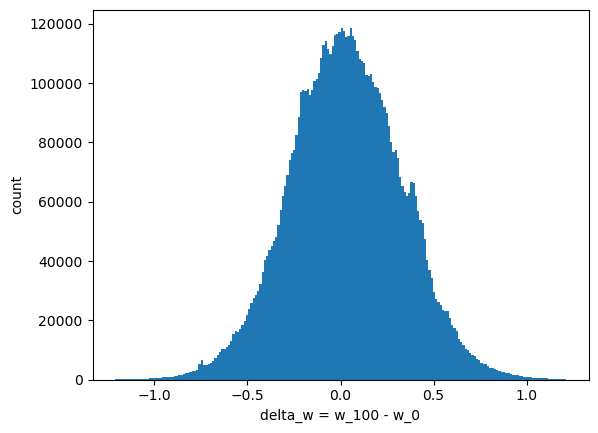

In [91]:
r = gpt_diff_weights.std().item() * 4

plt.hist(gpt_diff_weights.cpu().detach().numpy(), bins=200, range=(-r, r))
plt.xlabel('delta_w = w_100 - w_0')
plt.ylabel('count')
plt.show()

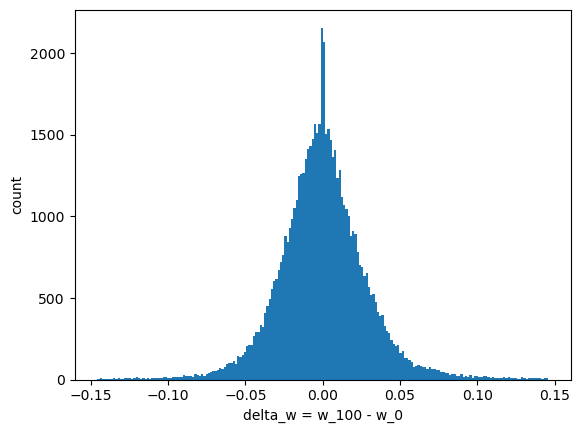

In [154]:
r = trained_weight.std().item() * 4

plt.hist(trained_weight.cpu().detach().numpy(), bins=200, range=(-r, r))
plt.xlabel('delta_w = w_100 - w_0')
plt.ylabel('count')
plt.show()

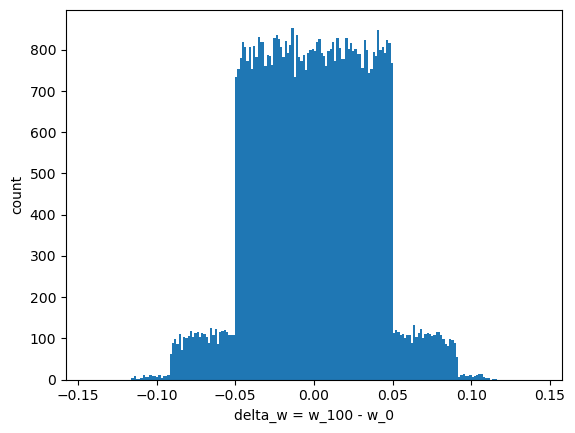

In [155]:
r = inited_weight.std().item() * 4

plt.hist(inited_weight.cpu().detach().numpy(), bins=200, range=(-r, r))
plt.xlabel('delta_w = w_100 - w_0')
plt.ylabel('count')
plt.show()

In [65]:

import math
import os
import sys
from functools import partial
from itertools import chain
from pathlib import Path
from dataclasses import dataclass, field

import numpy as np
import pandas as pd
import wandb
from tqdm import tqdm
from absl import logging

import torch
from transformers import (
    HfArgumentParser,
    TrainingArguments,
    MODEL_FOR_CAUSAL_LM_MAPPING,
    set_seed,
    AutoConfig,
    AutoTokenizer,
    CONFIG_MAPPING,
    AutoModelForCausalLM,
)
from transformers.training_args import OptimizerNames
from datasets import load_dataset
from accelerate import Accelerator

import torchopt
from torch.func import grad, grad_and_value, vmap, functional_call

from grabngo import GraBSampler, BalanceType
from grabngo.utils import EventTimer, pretty_time

In [72]:

@torch.no_grad()
def validate(eval_loader, model, device="cuda", disable_tqdm=False):
    losses = []
    for step, batch in tqdm(
            enumerate(eval_loader),
            total=len(eval_loader),
            desc="eval",
            leave=True,
            disable=disable_tqdm,
    ):
        # for step, batch in enumerate(eval_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        for k, v in batch.items():
            b = v.size(0)
            break
        outputs = model(**batch)
        loss = outputs.loss
        losses.append(loss.repeat(b))
    losses = torch.cat(losses)

    eval_loss = losses.mean()
    try:
        perplexity = torch.exp(eval_loss)
    except OverflowError:
        perplexity = float("inf")

    return eval_loss, perplexity

In [68]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
block_size = 128

raw_datasets = load_dataset('wikitext', 'wikitext-103-raw-v1')
# Preprocessing the datasets.
# First we tokenize all the texts.
column_names = raw_datasets["train"].column_names
text_column_name = "text" if "text" in column_names else column_names[0]


def tokenize_function(examples):
    return tokenizer(examples[text_column_name])


tokenized_datasets = raw_datasets.map(
    tokenize_function,
    batched=True,
    num_proc=64,
    remove_columns=column_names,
    desc="Running tokenizer on dataset",
)


# Main data processing function that will concatenate all texts from our dataset and generate chunks of block_size.
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i: i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result


# Note that with `batched=True`, this map processes 1,000 texts together, so group_texts throws away a remainder
# for each of those groups of 1,000 texts. You can adjust that batch_size here but a higher value might be slower
# to preprocess.
#
# To speed up this part, we use multiprocessing. See the documentation of the map method for more information:
# https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.map

lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True,
    num_proc=32,
    desc=f"Grouping texts in chunks of {block_size}",
)
# lm_datasets  = lm_datasets['train'].train_test_split(test_size=0.1)

train_dataset = lm_datasets["train"]
eval_dataset = lm_datasets["test"]
train_dataset = train_dataset.with_format('torch')
eval_dataset = eval_dataset.with_format('torch')

Found cached dataset wikitext (/home/aris/.cache/huggingface/datasets/wikitext/wikitext-103-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


  0%|          | 0/3 [00:00<?, ?it/s]

Running tokenizer on dataset (num_proc=64):   0%|          | 0/4358 [00:00<?, ? examples/s]

Running tokenizer on dataset (num_proc=64):   0%|          | 0/1801350 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1063 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1581 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1369 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1132 > 1024). Running this sequence through the model will result in indexing errors


Running tokenizer on dataset (num_proc=64):   0%|          | 0/3760 [00:00<?, ? examples/s]

Grouping texts in chunks of 128 (num_proc=32):   0%|          | 0/4358 [00:00<?, ? examples/s]

Grouping texts in chunks of 128 (num_proc=32):   0%|          | 0/1801350 [00:00<?, ? examples/s]

Grouping texts in chunks of 128 (num_proc=32):   0%|          | 0/3760 [00:00<?, ? examples/s]

In [104]:
clusters, centroids = kmeans1d.cluster(gpt_diff_weights.cpu().detach().numpy(), 16)

# print(clusters)
print(centroids)

quant_diff = torch.tensor(np.array(centroids)[clusters], dtype=torch.float32,
                          device='cuda')
print(quant_diff)

set_seed(42)

inited_model = AutoModelForCausalLM.from_config(config).cuda()

apply_diff(inited_model, quant_diff, replace=False)

diff_model = inited_model

set_seed(42)

inited_model = AutoModelForCausalLM.from_config(config).cuda()

assert not torch.allclose(next(inited_model.parameters()),
                          next(diff_model.parameters()))

[-0.8222818579931525, -0.5940587216306226, -0.44306975116261355, -0.3274628834732313, -0.2311017880987646, -0.14583663827414564, -0.06306767408619203, 0.018833130646877305, 0.10068584516604297, 0.18618717050542094, 0.2745056735532867, 0.37212909149606466, 0.4720222072347902, 0.6082372215365854, 0.8085219106234027, 1.2300597982103216]
tensor([-0.1458, -0.0631,  0.3721,  ..., -0.3275,  0.6082,  0.4720],
       device='cuda:0')


In [105]:
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=64, shuffle=False)

eval_loss, eval_perplexity = validate(eval_loader, inited_model)

print(eval_loss, eval_perplexity)

eval: 100%|██████████| 35/35 [00:00<00:00, 39.81it/s]

tensor(10.8445, device='cuda:0') tensor(51250.3477, device='cuda:0')


In [106]:
eval_loss, eval_perplexity = validate(eval_loader, gpt_trained)

print(eval_loss, eval_perplexity)

eval: 100%|██████████| 35/35 [00:00<00:00, 36.63it/s]

tensor(4.0901, device='cuda:0') tensor(59.7439, device='cuda:0')


In [107]:
eval_loss, eval_perplexity = validate(eval_loader, diff_model)

print(eval_loss, eval_perplexity)

eval: 100%|██████████| 35/35 [00:00<00:00, 39.34it/s]

tensor(6.6638, device='cuda:0') tensor(783.5311, device='cuda:0')


In [111]:
def per_layer_quant(model_init, model_trained, num_bits=2):
    diff = subtract(model_trained, model_init)

    for k, v in diff.items():
        print(k)
        shape = v.shape
        v = v.flatten()
        clusters, centroids = kmeans1d.cluster(v.cpu().detach().numpy(), 2 ** num_bits)
        # print(centroids)
        quant_diff = torch.tensor(np.array(centroids)[clusters], dtype=torch.float32,
                                  device='cuda')
        diff[k] = quant_diff

    apply_diff(model_init, torch.cat([v for v in diff.values()]), replace=False)

    return model_init


set_seed(42)

inited_model = AutoModelForCausalLM.from_config(config).cuda()
model_diff = per_layer_quant(inited_model, gpt_trained, num_bits=5)

set_seed(42)

inited_model = AutoModelForCausalLM.from_config(config).cuda()

assert not torch.allclose(next(inited_model.parameters()),
                          next(model_diff.parameters()))

transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_proj.weight
transformer.h.1.mlp.c_proj.bias
transformer.h.2.ln_1.weight
transformer.h.2.ln_1.bias
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_attn.bias
transformer.h.2.attn.c_proj.weight
transformer.h.2.attn.c_proj.bias
transformer.h.2.ln_2

In [151]:
def per_layer_quant(model_init, model_trained, linear=False, replace=False, num_bits=2):
    diff = subtract(model_trained, model_init) if not replace else dict(model_trained.named_parameters())

    for k, v in diff.items():
        print(k)
        v = v.flatten()
        if linear:
            v_min = v.min()
            s = (v.max() - v_min) / ((2 ** num_bits) - 1)
            z = (-2 ** (num_bits - 1) - v_min / s).round()
            quant_diff = ((v / s + z).round().float() - z) * s
        else:
            clusters, centroids = kmeans1d.cluster(v.cpu().detach().numpy(),
                                                   2 ** num_bits)
            # print(centroids)
            quant_diff = torch.tensor(np.array(centroids)[clusters],
                                      dtype=torch.float32,
                                      device='cuda')
        diff[k] = quant_diff

    apply_diff(model_init, torch.cat([v for v in diff.values()]), replace=replace)

    return model_init


set_seed(42)

inited_model = AutoModelForCausalLM.from_config(config).cuda()
model_diff = per_layer_quant(inited_model, gpt_trained, linear=False, replace=False, num_bits=4)

set_seed(42)

inited_model = AutoModelForCausalLM.from_config(config).cuda()

assert not torch.allclose(next(inited_model.parameters()),
                          next(model_diff.parameters()))

transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
transformer.h.1.mlp.c_fc.weight
transformer.h.1.mlp.c_fc.bias
transformer.h.1.mlp.c_proj.weight
transformer.h.1.mlp.c_proj.bias
transformer.h.2.ln_1.weight
transformer.h.2.ln_1.bias
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_attn.bias
transformer.h.2.attn.c_proj.weight
transformer.h.2.attn.c_proj.bias
transformer.h.2.ln_2

In [152]:
eval_loss, eval_perplexity = validate(eval_loader, model_diff)

print(eval_loss, eval_perplexity)

eval: 100%|██████████| 35/35 [00:00<00:00, 35.07it/s]

tensor(4.5278, device='cuda:0') tensor(92.5569, device='cuda:0')
